In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.metrics import silhouette_score
import pandas as pd
import plotly.express as px
from sklearn.base import TransformerMixin, BaseEstimator
import category_encoders as ce
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.ensemble import StackingRegressor
#from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
import optuna
from functions import *
import logging
import warnings 
import pickle
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

In [2]:
fmt = '%(asctime)s %(levelname)s %(lineno)s %(message)s'
logging.basicConfig(level='INFO', format=fmt, filename='log.log', filemode='a') 
logger = logging.getLogger('logit')

## Familiarization with data

In [3]:
# data parsed on the 1st step. Object type 'dacha'
df_dacha = pd.read_csv('data/country_houses.csv').drop(['Unnamed: 0'], axis=1)
print(df_dacha.shape)
print(f"Duplicates found: {df_dacha[df_dacha.duplicated].shape[0]}")
df_dacha.head(3)

(3052, 52)
Duplicates found: 0


,index,Тип объекта,Площадь участка,Площадь общая,Площадь жилая,Уровней в доме,Год постройки,Процент готовности,Материал стен,Материал крыши,...,Камин,Строительные материалы,Район города,Беседка,Микрорайон,Новостройка,Бассейн,Элитный коттедж,Пруд на участке,Аукцион
0,3289189,['Дача'],"['10.38', 'соток']","['16.7', 'м²']","['12', 'м²']",['1'],['2000'],['100'],['Дерево'],['Шифер'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3045903,['Дача'],"['7.55', 'соток']","['60.2', 'м²']","['43.1', 'м²']",['2'],['1991'],NaN,"['Блок', 'газосиликатный']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3292051,['Дача'],"['5', 'соток']","['80.8', 'м²']","['60', 'м²']",['3'],NaN,['100'],"['Красный', 'кирпич']",['Шифер'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# data parsed on the 2nd step.
df_cottage = pd.read_csv('data/country_houses_2.csv').drop(['Unnamed: 0'], axis=1)
print(df_cottage.shape)
print(f"Duplicates found: {df_cottage[df_cottage.duplicated].shape[0]}")
df_cottage.head(3)


(13135, 52)
Duplicates found: 0


,index,Тип объекта,Площадь участка,Ширина застройки,Длина застройки,Год постройки,Материал стен,Материал крыши,Ремонт,Отопление,...,Элитный коттедж,Камин,Хозпостройки,Строительные материалы,Направление,Мебель,Баня,Пруд на участке,Новостройка,Аукцион
0,3032596,['Дом'],"['11', 'соток']","['5', 'м']","['7', 'м']",['2008'],"['Брус', 'оцилиндрованный']",['Шифер'],"['Не', 'достроен']",['Печное'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3237237,['Дом'],"['12', 'соток']",NaN,NaN,NaN,['Блочный'],['Шифер'],NaN,"['На', 'газу']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3201241,['Дом'],"['13', 'соток']",NaN,NaN,['2004'],"['Дерево,', 'обложено', 'кирпичом']",['Шифер'],NaN,"['На', 'газу']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<i> Data fields </i>
* 'Тип объекта' - Object type
* 'Номер договора' - Contract number
* 'Возможен торг' - Negotiable
* 'Номер дома' - House number
* 'Условия продажи' - Terms of sale
* 'Аукцион' - Auction
* 'index' - ad's id
* 'Площадь участка' - Land area
* 'Площадь общая' - Total area
* 'Уровней в доме' - house levels
* 'Год постройки' - year of construction
* 'Процент готовности' - percentage of readiness
* 'Координаты' - house coordinates
* 'Площадь жилая' - living area
* 'Площадь кухни' - kitchen area
* 'Ширина застройки' - building width
* 'Длина застройки' - building length
* 'Материал стен' - wall material
* 'Материал крыши' - roof material
* 'Отопление' - heating
* 'Канализация' - sewerage
* 'Электроснабжение' - electricity
* 'Вода' - water supply
* 'Телефон' - phone
* 'Область' - region
* 'Район' - district
* 'Населенный пункт' - city/town
* 'Сельсовет' - village council
* 'Газ' - if there ia gas
* 'Баня' - if there is a sauna
* 'Гараж' - if there is a garage
* 'Статус земли' - land status
* 'Сад' - if there is a garden
* 'Хозпостройки' - if there are outbuildings
* 'Рядом лес' - if there is a forrest nearby
* 'Водоем' - if there is a pond nearby
* 'Ландшафтный дизайн' - landscape design
* 'Улица' - street name
* 'Теплица' - if there is a glasshouse
* 'Мебель' - if there is a furniture
* 'Направление' - direction
* 'Ремонт' - interior renovation type
* 'Камин' - if there is a fireplace in the house
* 'Строительные материалы' - building materials
* 'Район города' - city district
* 'Беседка' - if there is a 'small-talk' pavilion 
* 'Микрорайон' - subdistrict
* 'Новостройка' - if house is new (just finished)
* 'Бассейн' - if there is a swimming pool
* 'Элитный коттедж' - if house is elite
* 'Пруд на участке' - if there is a pond
* 'Цена' - price, TARGET feature

In [5]:
# columns in both datasets are the same, so they can be concated
set(df_cottage.columns).symmetric_difference(set(df_dacha.columns))

set()

In [6]:
df = pd.concat([df_dacha, df_cottage], axis=0)
df.shape

(16187, 52)

In [7]:
print(f"nan in price column: {df['Цена'].isna().sum()}")
df = df[df['Цена'].notna()]
df.shape

nan in price column: 749


(15438, 52)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15438 entries, 0 to 13134
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   15438 non-null  int64  
 1   Тип объекта             15438 non-null  object 
 2   Площадь участка         15218 non-null  object 
 3   Площадь общая           14022 non-null  object 
 4   Площадь жилая           11067 non-null  object 
 5   Уровней в доме          12420 non-null  object 
 6   Год постройки           11558 non-null  object 
 7   Процент готовности      7911 non-null   object 
 8   Материал стен           13564 non-null  object 
 9   Материал крыши          11511 non-null  object 
 10  Отопление               12439 non-null  object 
 11  Канализация             11616 non-null  object 
 12  Электроснабжение        13151 non-null  object 
 13  Вода                    13294 non-null  object 
 14  Телефон                 2348 non-null   obj

В целевом признаке есть пропущенные значения. Это обусловлено тем, что в части объявлений цена была обозначена как "Договорная", без цифрового определения
Для наглядности, отобразим объекты из объявлений на карте Беларуси.
_____________
there are missed values in target feature. this is because for these ads the price was designated as 'Договорная'
Let's draw the houses coordinates on Belarus map

In [9]:
color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df, 
                        lat=df['Координаты'].dropna().apply(lambda x: float(re.findall(r"\'(\d{2}\.\d{1,}).", str(x))[0])), 
                        lon=df['Координаты'].dropna().apply(lambda x: float(re.findall(r"\'(\d{2}\.\d{1,}).", str(x))[1])),  
                        #hover_name="Address", 
                        #hover_data=["Address", "Listed"],
                        #color="Listed",
                        color_continuous_scale=color_scale,
                        #size="Listed",
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Визуализация демонстрирует, что объекты сгруппированы недалеко от городов. самые крупные кластеры расположены вблизи областных центров: Минск, Брест, Гродно, Витебск, Могилев, Гомель.
____
It's obvious that the houses are grouped near city. the biggest clusters are near regional centers: Minsk, Brest, Grodno, Vitebsk, Mogilev, Gomel

## Feature processing. EDA

Обработка данных будет выполняться с помощью серии трансформеров, чтобы сделать эту процедуру более читаемой и понятной, а также облегчить ее использование в будущем. Начнем с преобразования числовых признаков
_________________
Data processing is going to be performed in several transformers, in order to have this procedure more reasonable and clear and facilitate future usability

In [10]:
class NUM_Transformer(TransformerMixin, BaseEstimator):
    '''Transform numeric features'''

    def __init__(self):
        pass


    def fit(self, X, y=None):
        '''
        '''
        return self


    def transform(self,X):
        ''''''
        X['land_area'] = X['Площадь участка'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_area'] = X['Площадь общая'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_levels'] = X['Уровней в доме'].apply(lambda x: int(re.findall(r"\d{1}", x)[0]) if x is not np.nan else x)
        X['house_year'] = X['Год постройки'].apply(lambda x: int(re.findall(r"\d{4}", x)[0]) if x is not np.nan else x)
        X['house_readiness'] = X['Процент готовности'].apply(lambda x: int(re.findall(r"\d{1,}", x)[0]) if x is not np.nan else x)
        #X['house_readiness'] = pd.cut(X.house_readiness.fillna(np.nan), [0,20,40,60,80,99,100, np.nan], labels = ['<20','20-40','40-60','60-80','80-99','100', 'unknown'])
        X['house_coordinates'] = X.loc[:,'Координаты'].apply(
            lambda x: (float(re.findall(r"\d{2}\.\d{1,}", x)[0]),float(re.findall(r"\d{2}\.\d{1,}", x)[1])) if x is not np.nan else x)
        X['price'] = X['Цена'].apply(
            lambda x: int(re.findall(r"(\d{1,}).", x.replace('\xa0',''))[0]) if x is not np.nan else x)            
            #lambda x: float(x.split()[0] + x.split()[1]))
        X['liv_house_area'] = X['Площадь жилая'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['kitchen_area'] = X['Площадь кухни'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_width'] = X['Ширина застройки'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_length'] = X['Длина застройки'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        
        # delete not processed features
        X.drop(['Площадь участка', 'Площадь общая', 'Уровней в доме', 'Год постройки', 'Процент готовности', 'Координаты', 'Цена',
              'Площадь жилая', 'Площадь кухни', 'Ширина застройки', 'Длина застройки'], axis=1, inplace=True)
        # drop following features wich contains plenty of nan-values
        X.drop(['kitchen_area', 'liv_house_area','house_length','house_width'], axis=1, inplace=True)

        # fill nan
        X = X.fillna({
            'house_readiness': X['house_readiness'].median(),
            'house_area': X['house_area'].median(), 
            'land_area': X['land_area'].median(),
            'house_coordinates': X['house_coordinates'].fillna(df.groupby('Населенный пункт')['house_coordinates'].transform(
                lambda x: str(x.value_counts().index[0]) if len(x.value_counts().index)>0 else np.nan))
        })

        X = X[X['house_coordinates'].notna()]  
        # remove the entries with price more than 500000. this improves the scores but this the topic to discuss. 
        # But it's obvious that price without restriction increases the price dispersion in the categories     
        X = X[(X['price']<400000) & (X['price']>1000)]

        print(f"DF shape after NUM_Transformer {X.shape}")

        return X
    

num_treat = NUM_Transformer()
df = num_treat.transform(df)

DF shape after NUM_Transformer (13030, 48)


In [11]:
df.columns

Index(['index', 'Тип объекта', 'Материал стен', 'Материал крыши', 'Отопление',
       'Канализация', 'Электроснабжение', 'Вода', 'Телефон', 'Условия продажи',
       'Номер договора', 'Область', 'Район', 'Населенный пункт', 'Номер дома',
       'Сельсовет', 'Газ', 'Баня', 'Гараж', 'Статус земли', 'Сад',
       'Хозпостройки', 'Возможен торг', 'Рядом лес', 'Водоем',
       'Ландшафтный дизайн', 'Улица', 'Теплица', 'Мебель', 'Направление',
       'Ремонт', 'Камин', 'Строительные материалы', 'Район города', 'Беседка',
       'Микрорайон', 'Новостройка', 'Бассейн', 'Элитный коттедж',
       'Пруд на участке', 'Аукцион', 'land_area', 'house_area', 'house_levels',
       'house_year', 'house_readiness', 'house_coordinates', 'price'],
      dtype='object')

In [12]:
# divide features in two groupes
num_features = ['land_area', 'house_area', 'house_readiness',  'price',]
cat_features = [item for item in df.columns if item not in num_features]


In [13]:
categories = df[cat_features].nunique().sort_values(ascending=False)
display(categories)

index                     13029
house_coordinates         10807
Номер договора             8280
Населенный пункт           4425
Улица                      2040
Сельсовет                   788
Направление                 761
Номер дома                  399
Микрорайон                  148
house_year                  121
Район                       118
Материал стен                22
Район города                 14
Материал крыши               13
Вода                         11
Отопление                    10
Ремонт                        7
Статус земли                  7
Область                       6
Условия продажи               6
Канализация                   5
Электроснабжение              5
Тип объекта                   5
house_levels                  5
Газ                           5
Телефон                       3
Пруд на участке               1
Элитный коттедж               1
Бассейн                       1
Аукцион                       1
Новостройка                   1
Беседка 

In [14]:
df.isna().sum().sort_values(ascending=False)

Аукцион                   12954
Бассейн                   12918
Элитный коттедж           12855
Пруд на участке           12705
Новостройка               12542
Строительные материалы    12525
Камин                     12204
Теплица                   11844
Беседка                   11833
Микрорайон                11793
Район города              11747
Ремонт                    11327
Телефон                   11145
Баня                      11127
Мебель                    10436
Направление               10363
Гараж                     10179
Сад                        9511
Водоем                     8903
Ландшафтный дизайн         8855
Номер дома                 8777
Рядом лес                  8247
Возможен торг              8220
Хозпостройки               7714
Сельсовет                  6283
Улица                      6096
Номер договора             4524
Газ                        4360
house_year                 3646
Канализация                3465
Материал крыши             3289
house_le

Т.о. в наборе данных присутствуют признаки с большим количеством уникальных значений и большим количеством пропусков.
______________
So there are many features with too many unique values and with plenty of nans. we need to handle it

In [15]:
df.drop(['Аукцион', 'index', 'Номер договора', 'Улица', 'Номер дома', 'Микрорайон', 'Район города', 'Возможен торг'], axis=1, inplace=True)
cat_features = [item for item in df.columns if item not in num_features]

categories = df.loc[:, cat_features].nunique().sort_values(ascending=False) 
categories


house_coordinates         10807
Населенный пункт           4425
Сельсовет                   788
Направление                 761
house_year                  121
Район                       118
Материал стен                22
Материал крыши               13
Вода                         11
Отопление                    10
Статус земли                  7
Ремонт                        7
Условия продажи               6
Область                       6
house_levels                  5
Тип объекта                   5
Канализация                   5
Электроснабжение              5
Газ                           5
Телефон                       3
Гараж                         1
Строительные материалы        1
Пруд на участке               1
Элитный коттедж               1
Бассейн                       1
Новостройка                   1
Беседка                       1
Камин                         1
Сад                           1
Мебель                        1
Теплица                       1
Ландшафт

### Binary categories

Обработаем категории с уникальными 1-3 уникальными значениями. 3 - для признака 'телефон', мы не будем учитывать их количество, только наличие
_____________
Let's process categories with unique 1-3 unique values. 3 - for phone, but indeed it means 1 - it's available

In [16]:
bin_categories = categories[categories<=3]
print(bin_categories)

Телефон                   3
Гараж                     1
Строительные материалы    1
Пруд на участке           1
Элитный коттедж           1
Бассейн                   1
Новостройка               1
Беседка                   1
Камин                     1
Сад                       1
Мебель                    1
Теплица                   1
Ландшафтный дизайн        1
Водоем                    1
Рядом лес                 1
Баня                      1
Хозпостройки              1
dtype: int64


In [17]:
display(df['Беседка'].value_counts())
display(df['Камин'].value_counts())
display(df['Телефон'].value_counts())

Беседка
1.0    1197
Name: count, dtype: int64

Камин
['Да']    826
Name: count, dtype: int64

Телефон
['Есть']             1871
['2', 'телефона']      11
['3', 'телефона']       3
Name: count, dtype: int64

In [18]:
class BIN_Transformer(TransformerMixin, BaseEstimator):
    '''Transform binary categories'''

    def __init__(self, bin_categories):
        self.categories = bin_categories
        
    def fit(self, X, y=None):
        return self

    def transform(self,X):
        ''''''
        for item in self.categories.index:
            X[item] = X[item].apply(lambda x: 0 if pd.isna(x) else 1)     
        
        print(f"DF shape after BIN_Transformer {X.shape}")

        return X
    

bin_treat = BIN_Transformer(bin_categories)
df = bin_treat.transform(df)

DF shape after BIN_Transformer (13030, 40)


### Multi options categories 

Признаки из этой группы содержат более 3-х уникальных значений. Разделим их на 3 подгруппы для облегчения обработки.
_____________
Features from this group contains more than 3 uniques. We'll shortly divide them in 3 subgroupes to facilitate processing 

In [19]:
multi_categories = categories[categories>3]
display(multi_categories)


house_coordinates    10807
Населенный пункт      4425
Сельсовет              788
Направление            761
house_year             121
Район                  118
Материал стен           22
Материал крыши          13
Вода                    11
Отопление               10
Статус земли             7
Ремонт                   7
Условия продажи          6
Область                  6
house_levels             5
Тип объекта              5
Канализация              5
Электроснабжение         5
Газ                      5
dtype: int64

In [20]:
df[multi_categories.index].isna().sum().sort_values(ascending=False) #/ df.shape[0]

Ремонт               11327
Направление          10363
Сельсовет             6283
Газ                   4360
house_year            3646
Канализация           3465
Материал крыши        3289
house_levels          2805
Отопление             2637
Электроснабжение      2026
Условия продажи       1950
Вода                  1930
Статус земли          1787
Материал стен         1643
Район                   96
Населенный пункт         0
Область                  0
Тип объекта              0
house_coordinates        0
dtype: int64

In [21]:
# divide in groupes according 'fill nan' strategy
fill_na_net = ['Электроснабжение', 'Вода', 'Отопление', 'Канализация', 'Газ']
fill_na_mode = ['Материал крыши', 'house_levels', 'Статус земли', 'Материал стен', 'Тип объекта', 'Условия продажи', 'Ремонт']
fill_na_manage = ['Направление', 'Сельсовет', 'Район', 'Область', 'house_year', 'Населенный пункт']


### Multi options categories. Fill NAN with 'net'

In [22]:
fill_na_net

['Электроснабжение', 'Вода', 'Отопление', 'Канализация', 'Газ']

Прежде чем применить преобразование, мы проверим статистическую значимость различий для вариантов категорий, которые кажутся одинаковыми.

Например:

особенность - «Вода», опции:
1. «['Нет']»,
2. «['Рядом']»

функция - «Канализация», опции:
1. "['С/у', 'на', 'улице']",
2. «['Нет']»

и т. д.

объединение вариантов со схожим распределением позволит сократить список входящих в модель признаков. если разница между вариантами не является статистически значимой, функция предлагает заменить одно на другое, у которого больше значений в наборе данных
______________
Before applying transformation we'll check statistical difference significance for category options which seems to be the same. 

For example: 

feature - 'Вода', options: 
1. "['Нет']", 
2. "['Рядом']" 

feature - 'Канализация', options: 
1. "['С/у', 'на', 'улице']", 
2. "['Нет']"

etc

merging options with similar distribution will allow us to shorten the list of features entering the model. if the difference between is not statistically significante, the function proposes to substitute one with another which has more counts in data set

In [23]:
print(stat_compare(df,'Канализация', "['С/у', 'на', 'улице']", "['Нет']"))
print(stat_compare(df,'Канализация', "['Местная']", "['Центральная']"))

print(stat_compare(df,'Электроснабжение', "['Рядом']", "['Нет']"))
print(stat_compare(df,'Электроснабжение', "['Есть']", "['220В']"))

print(stat_compare(df,'Вода', "['Рядом', 'колодец']", "['Рядом']"))
print(stat_compare(df,'Вода', "['Рядом', 'водопровод']", "['Рядом']"))
print(stat_compare(df,'Вода', "['Нет']", "['Рядом']"))

print(stat_compare(df,'Отопление', "['На', 'газу']", "['Паровое']"))
print(stat_compare(df,'Отопление', "['Паровое', 'на', 'твёрдом', 'топливе']", "['Паровое']"))
print(stat_compare(df,'Отопление', "['Паровое', 'на', 'жидком', 'топливе']", "['Паровое']"))

КАНАЛИЗАЦИЯ ['С/у', 'на', 'улице'] (1), ['Нет'] (1): EQUAL --> ['С/у', 'на', 'улице']
КАНАЛИЗАЦИЯ ['Местная'] (1), ['Центральная'] (1): not equal
ЭЛЕКТРОСНАБЖЕНИЕ ['Рядом'] (1), ['Нет'] (1): not equal
ЭЛЕКТРОСНАБЖЕНИЕ ['Есть'] (1), ['220В'] (1): not equal
ВОДА ['Рядом', 'колодец'] (1), ['Рядом'] (1): not equal
ВОДА ['Рядом', 'водопровод'] (1), ['Рядом'] (1): not equal
ВОДА ['Нет'] (1), ['Рядом'] (1): not equal
ОТОПЛЕНИЕ ['На', 'газу'] (1), ['Паровое'] (1): not equal
ОТОПЛЕНИЕ ['Паровое', 'на', 'твёрдом', 'топливе'] (1), ['Паровое'] (1): not equal
ОТОПЛЕНИЕ ['Паровое', 'на', 'жидком', 'топливе'] (1), ['Паровое'] (1): not equal


мы видим, что разница между вариантами ['С/у', 'на', 'улице'] (1) , ['Нет'] (1) для признака КАНАЛИЗАЦИЯ не является статистически значимой. рекомендованное значение для замены с более высокой частотой встречаемости. значение в скобках после названия варианта — результат проверки на нормальность: 1 — альтернативная гипотеза (не норм)
_____________
we see that the difference between the options  ['С/у', 'на', 'улице'] (1) , ['Нет'] (1) for feature КАНАЛИЗАЦИЯ is not statistically significant. recommended the value for replacement with higher occurrence. the value in brackets after the option name is the result of the normality test: 1 - alternative hypothesis (not normal)

In [24]:
class CAT_1_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be fillna with "no" '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        X['Газ'] = X['Газ'].map({
            "['Рядом']":'рядом', 
            "['Есть']":'есть', 
            "['Нет']":'нет',
            "['Баллон']":'нет',
            "['Магистральный']":'есть',            
            }) 

        X['Канализация'] = X['Канализация'].map({
            "['С/у', 'на', 'улице']":'с/у наружн.', 
            "['Местная']":'местная', 
            "['Есть']":'есть', 
            "['Центральная']":'центральн.', 
            "['Нет']":'с/у наружн.',
            })

        X['Электроснабжение'] = X['Электроснабжение'].map({
            "['Есть']":'есть', 
            "['220В']":'есть', 
            "['Рядом']":'рядом', 
            "['380В']":'380В', 
            "['Нет']":'нет',
            })

        X['Отопление'] = X['Отопление'].map({
            "['На', 'газу']":'паровое г.',
            "['Печное']":'печь', 
            "['Электрическое']":'электрич.',
            "['Нет']":'нет', 
            "['Центральное']":'центральн.',
            "['Паровое', 'на', 'твёрдом', 'топливе']":'паровое т.', 
            "['Паровое', 'на', 'газу']":'паровое г.', 
            "['Паровое', 'на', 'жидком', 'топливе']":'паровое ж.',
            "['Паровое']":'паровое',
            "['Альтернативные', 'источники']":'альтерн.',             
            })
        
        X['Вода'] = X['Вода'].map({
            "['Центральный', 'водопровод']":'водопровод',
            "['Скважина']":'скважина', 
            "['Колодец']":'колодец',
            "['Сезонная']":'сезонная', 
            "['Горячая']":'горячая',
            "['Холодная']":'холодная',
            "['Рядом']":'рядом',
            "['Рядом', 'колодец']":'рядом колодец',
            "['Нет']":'нет',
            "['Рядом', 'водопровод']":'рядом',
            "['Водопровод']":'водопровод'
            })

        # fill nan-values
        X[self.categories] = X[self.categories].fillna('нет')

        print(f"DF shape after CAT_1_Transformer {X.shape}")

        return X
    

cat_1_treat = CAT_1_Transformer(fill_na_net)
df = cat_1_treat.transform(df)

DF shape after CAT_1_Transformer (13030, 40)


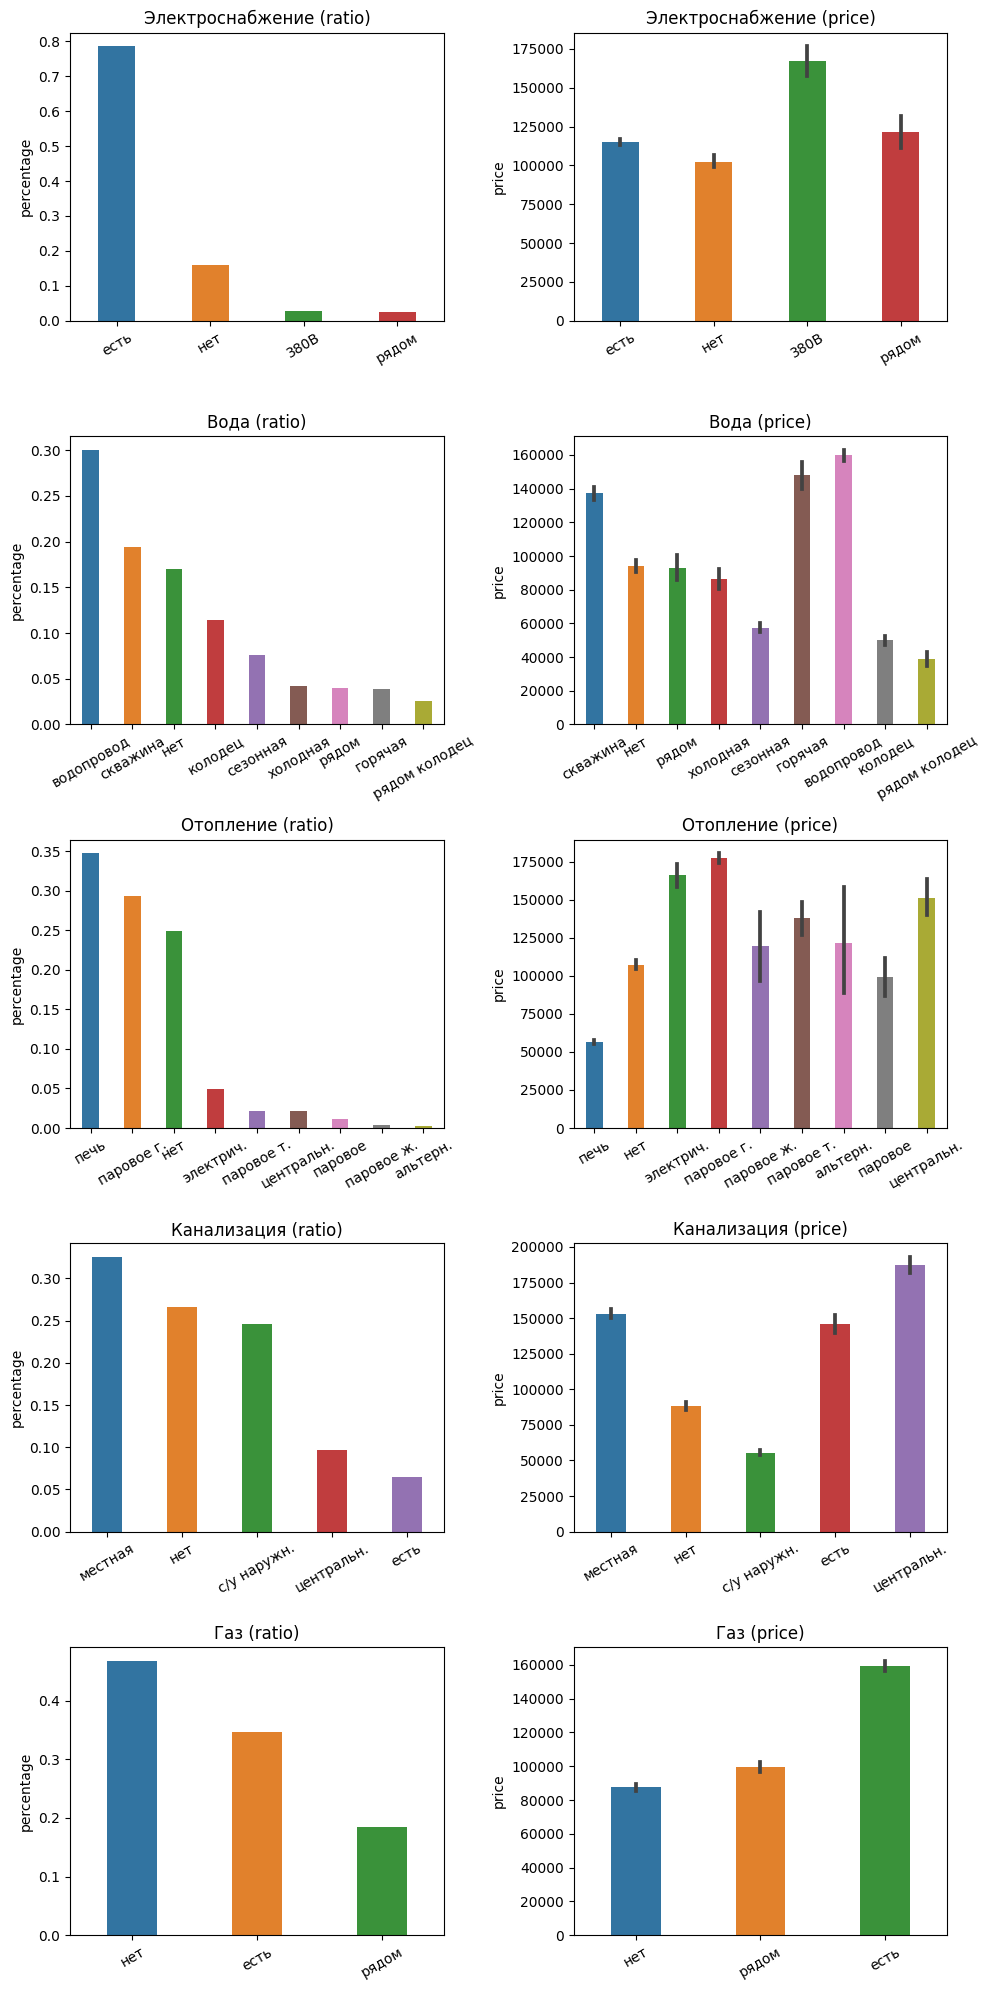

In [25]:
draw_categories(df,fill_na_net)

Визуализированные зависимости кажутся в целом логичными.
* самые высокие цены на дома, оборудованные электричеством 380В.
* самые высокие цены указаны для домов с водопроводом и горячей водой
* самые высокие цены на дома с паровым, газовым, электрическим или центральным отоплением
* самые высокие цены — на дома с канализацией, самые низкие — с удобствами снаружи дома
* наличие газа также приводит к увеличению стоимости.
_______________
The visualized dependencies seem generally logical.
* the highest prices for houses equipped with 380V electricity
* the highest prices are for houses equipped with running water and hot water
* the highest prices for houses with steam gas, electric or central heating
* the highest prices are for houses equipped with sewerage, the lowest - with amenities outside the house
* the presence of gas also leads to an increase in cost.

### Multi options categories. Fill NAN with mode-value

Следующая группа — это те признаки, в которых пропущенные значения будут заполнены модальным значением
_______________
The next group is those features in which missing values will be filled in with a mode-value

In [26]:
fill_na_mode

['Материал крыши',
 'house_levels',
 'Статус земли',
 'Материал стен',
 'Тип объекта',
 'Условия продажи',
 'Ремонт']

In [27]:
print(stat_compare(df,'Материал стен', "['Блок', 'газосиликатный']", "['Блочный']"))
print(stat_compare(df,'Материал стен', "['Силикатные', 'блоки']", "['Блочный']"))
print(stat_compare(df,'Материал стен', "['Блок', 'газосиликатный']", "['Силикатные', 'блоки']"))
print(stat_compare(df,'Материал стен', "['Белый', 'кирпич']", "['Кирпичный']"))
print(stat_compare(df,'Материал стен', "['Белый', 'кирпич']", "['Красный', 'кирпич']"))
print(stat_compare(df,'Материал стен', "['Красный', 'кирпич']", "['Кирпичный']"))
print(stat_compare(df,'Материал стен', "['Бревенчатый']", "['Сруб']"))

print(stat_compare(df,'Материал крыши', "['Металло-черепица']", "['Металл']"))
print(stat_compare(df,'Материал крыши', "['Ондулин']", "['Евро-шифер']"))
print(stat_compare(df,'Материал крыши', "['Мягкая', 'черепица']", "['Битумная', 'черепица']"))
print(stat_compare(df,'Материал крыши', "['Жесть']", "['Металл']"))
print(stat_compare(df,'Материал крыши', "['Рубероид']", "['Гидроизоляция']"))

print(stat_compare(df,'Тип объекта', "['Таунхаус']", "['Коттедж']"))

print(stat_compare(df,'Ремонт', "['Евроотделка,', 'отделка', 'деревом']", "['Евроотделка']"))
print(stat_compare(df,'Ремонт', "['Не', 'достроен,', 'отделка', 'деревом']", "['Не', 'достроен']"))


МАТЕРИАЛ СТЕН ['Блок', 'газосиликатный'] (1), ['Блочный'] (1): not equal
МАТЕРИАЛ СТЕН ['Силикатные', 'блоки'] (1), ['Блочный'] (1): not equal
МАТЕРИАЛ СТЕН ['Блок', 'газосиликатный'] (1), ['Силикатные', 'блоки'] (1): EQUAL --> ['Блок', 'газосиликатный']
МАТЕРИАЛ СТЕН ['Белый', 'кирпич'] (1), ['Кирпичный'] (1): not equal
МАТЕРИАЛ СТЕН ['Белый', 'кирпич'] (1), ['Красный', 'кирпич'] (1): not equal
МАТЕРИАЛ СТЕН ['Красный', 'кирпич'] (1), ['Кирпичный'] (1): EQUAL --> ['Кирпичный']
МАТЕРИАЛ СТЕН ['Бревенчатый'] (1), ['Сруб'] (1): not equal
МАТЕРИАЛ КРЫШИ ['Металло-черепица'] (1), ['Металл'] (1): not equal
МАТЕРИАЛ КРЫШИ ['Ондулин'] (1), ['Евро-шифер'] (1): EQUAL --> ['Ондулин']
МАТЕРИАЛ КРЫШИ ['Мягкая', 'черепица'] (1), ['Битумная', 'черепица'] (1): EQUAL --> ['Мягкая', 'черепица']
МАТЕРИАЛ КРЫШИ ['Жесть'] (1), ['Металл'] (1): not equal
МАТЕРИАЛ КРЫШИ ['Рубероид'] (1), ['Гидроизоляция'] (0): not equal
ТИП ОБЪЕКТА ['Таунхаус'] (1), ['Коттедж'] (1): not equal
РЕМОНТ ['Евроотделка,', 'отделка

по ряду признаков разница между вариантами статистически не значима, поэтому их можно объединить в теле трансформера
___________________
for several features the difference between the options is not statistically significant:

* МАТЕРИАЛ СТЕН ['Блок', 'газосиликатный'] (1), ['Силикатные', 'блоки'] (0): EQUAL --> ['Блок', 'газосиликатный']
* МАТЕРИАЛ СТЕН ['Красный', 'кирпич'] (1), ['Кирпичный'] (1): EQUAL --> ['Кирпичный']
* МАТЕРИАЛ КРЫШИ ['Ондулин'] (1), ['Евро-шифер'] (1): EQUAL --> ['Ондулин']
* МАТЕРИАЛ КРЫШИ ['Мягкая', 'черепица'] (1), ['Битумная', 'черепица'] (1): EQUAL --> ['Мягкая', 'черепица']
* РЕМОНТ ['Евроотделка,', 'отделка', 'деревом'] (1), ['Евроотделка'] (1): EQUAL --> ['Евроотделка']
* РЕМОНТ ['Не', 'достроен,', 'отделка', 'деревом'] (1), ['Не', 'достроен'] (1): EQUAL --> ['Не', 'достроен']

We'll take this into account for transformation

In [28]:
class CAT_2_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be fillna with mode-value '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''

        X['Тип объекта'] = X['Тип объекта'].map({
            "['Дом']":'дом',
            "['Дача']":'дача',
            "['Коттедж']":'коттедж', 
            "['Полдома']":'полдома',
            "['Таунхаус']":'таунхаус', 
            })

        X['Материал стен'] = X['Материал стен'].map({
            "['Дерево']":'дерево', 
            "['Кирпичный']":'кирпич', 
            "['Блок', 'газосиликатный']":'блок г/с', 
            "['Блочный']":'блок',
            "['Дерево,', 'обложено', 'кирпичом']":'дер., кирпич',
            "['Сруб']":'сруб',
            "['Брус', 'профилированный']":'брус профил.',
            "['Сборно-щитовой']":'сб-щитовой',
            "['Шлакобетон']":'шлакобетон',            
            "['Керамзитбетон']":'керамзитобетон',
            "['Каркасный', 'деревянный']":'каркасн. дер.',
            "['Белый', 'кирпич']":'кирпич бел.',
            "['Бревенчатый']":'бревенчатый',
            "['Силикатные', 'блоки']":'блок г/с',
            "['Красный', 'кирпич']":'кирпич',
            "['Панельный']":'панельн.',
            "['Брус', 'оцилиндрованный']":'брус оцил.',
            "['Каркасно-засыпной']":'другой',
            "['Облицовочный', 'кирпич']":'другой',
            "['Брус', 'клееный']":'другой',
            "['Монолитно-каркасный']":'другой',
            "['Блок-комнаты']":'другой'
            })

        X['Материал крыши'] = X['Материал крыши'].map({
            "['Шифер']":'шифер',
            "['Металло-черепица']":'черепица мет.', 
            "['Мягкая', 'черепица']":'черепица мяг.',
            "['Черепица']":'черепица',
            "['Ондулин']":'ондулин', 
            "['Металл']":'металл',
            "['Жесть']":'жесть',
            "['Евро-шифер']":'ондулин',
            "['Битумная', 'черепица']":'черепица мяг.',
            "['Рубероид']":'другой',
            "['Гидроизоляция']":'другой',
            "['Доски']":'другой',
            "['Природные', 'материалы']":'другой'
            })

        X['Статус земли'] = X['Статус земли'].map({
            "['Частная', 'собственность']":'частная',
            "['Пожизненно', 'наследуемое', 'владение']":'пожизн. насл.',
            "['Частная']":'частная', 
            "['Аренда']":'аренда',
            "['Пожизненноe', 'наследуемое', 'владение']":'пожизн. насл.', 
            "['Другое']":'другое', 
            "['Пользование']":'другое'
            })
        
        X['Ремонт'] = X['Ремонт'].map({
            "['Отделка', 'деревом']":'отделка дер.', 
            "['Не', 'достроен']":'не достроен',
            "['Евроотделка']":'евроотделка',
            "['Евроотделка,', 'отделка', 'деревом']":'евроотделка',
            "['Не', 'достроен,', 'отделка', 'деревом']":'не достроен',
            "['Евроотделка,', 'не', 'достроен']": 'не достроен',
            "['Евроотделка,', 'не', 'достроен,', 'отделка', 'деревом']":'не достроен'
            })

        X[self.categories] = X[self.categories].fillna(X.mode().iloc[0])
        X.drop(['Условия продажи'], axis=1, inplace=True)
        #X = X[X['Тип объекта']=='дача']
        
        print(f"DF shape after CAT_2_Transformer {X.shape}")

        return X
    

cat_2_treat = CAT_2_Transformer(fill_na_mode)
df = cat_2_treat.transform(df)

DF shape after CAT_2_Transformer (13030, 39)


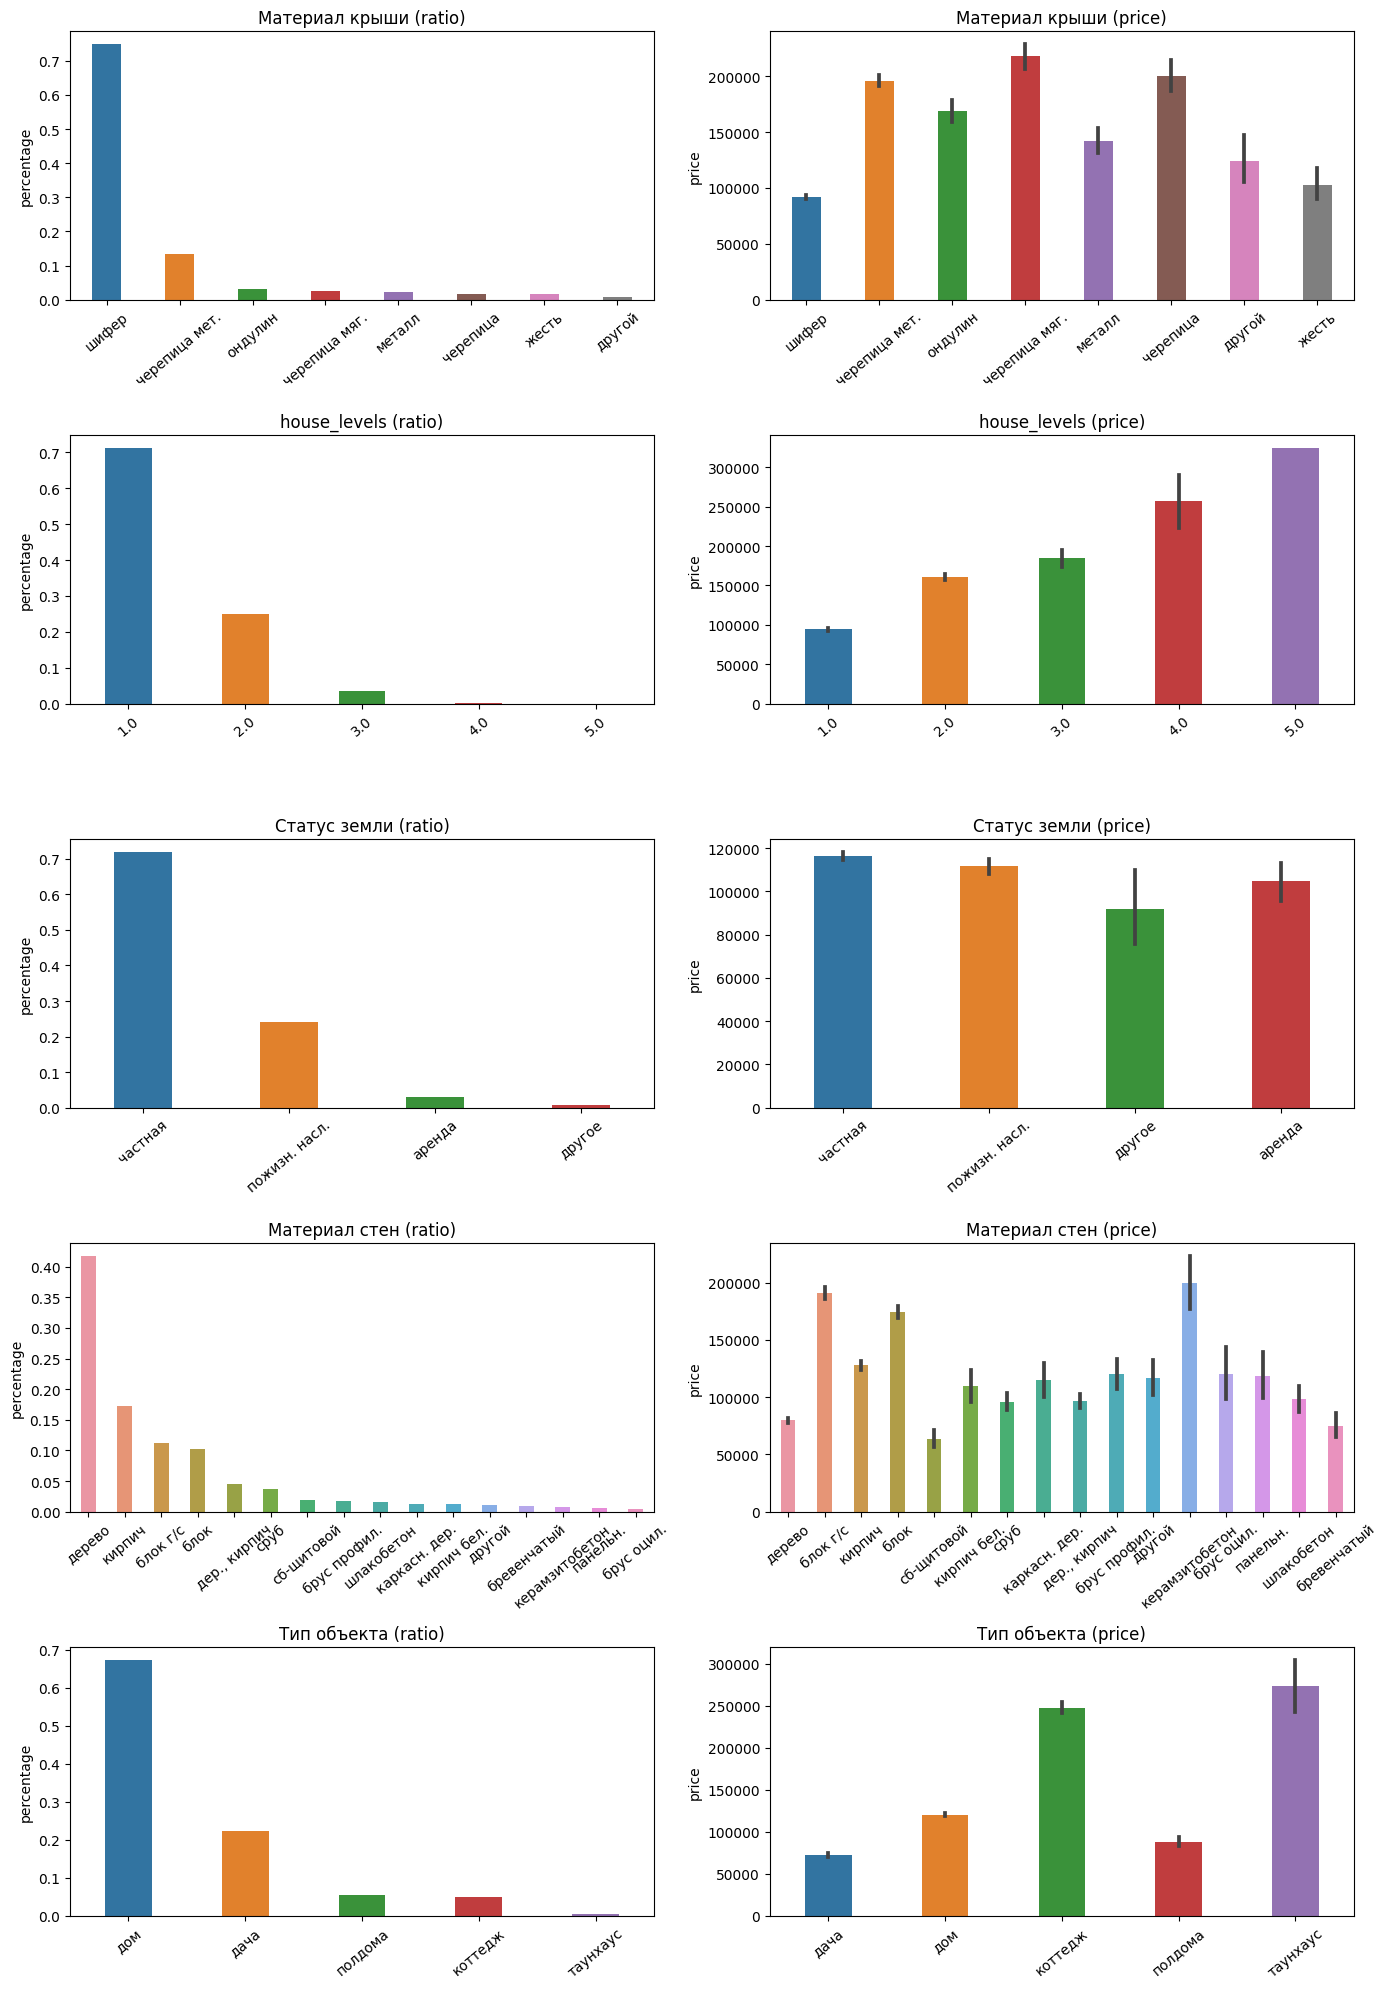

In [29]:
draw_categories(df,['Материал крыши', 'house_levels','Статус земли','Материал стен','Тип объекта'], 14, 40)

Эта группа категориальных признаков также демонстрирует вполне логичные закономерности:

* самый распространенный кровельный материал – шифер, который к тому же является самым дешевым
* с увеличением этажности растет и стоимость
* различия не существенны для статуса собственности
* самый популярный и дешевый материал для стен – дерево. дорогие – керамзитобетон и блок г/с
* самый дешевый тип объекта предсказуемо дача. самыми дорогими являются коттедж и таунхаус.
________________
This group of categorical features also shows quite logical patterns:

* the most common roofing material is slate, which is also one of the cheapest
* as the number of floors increases, so does the cost
* differences are not significant for ownership status
* the most popular and cheapest wall material is wood. expensive - expanded clay concrete and gypsum block
* the cheapest type of object is predictably a dacha. the most expensive are a cottage and a townhouse.



### Multi options categories. Manage to fill NAN

с точки зрения заполнения пропусков в этой группе ситуация должна быть несколько сложнее
_____________
from the point of view of filling in the gaps in this group the situation is supposed to be a little more complicated

In [30]:
fill_na_manage

['Направление',
 'Сельсовет',
 'Район',
 'Область',
 'house_year',
 'Населенный пункт']

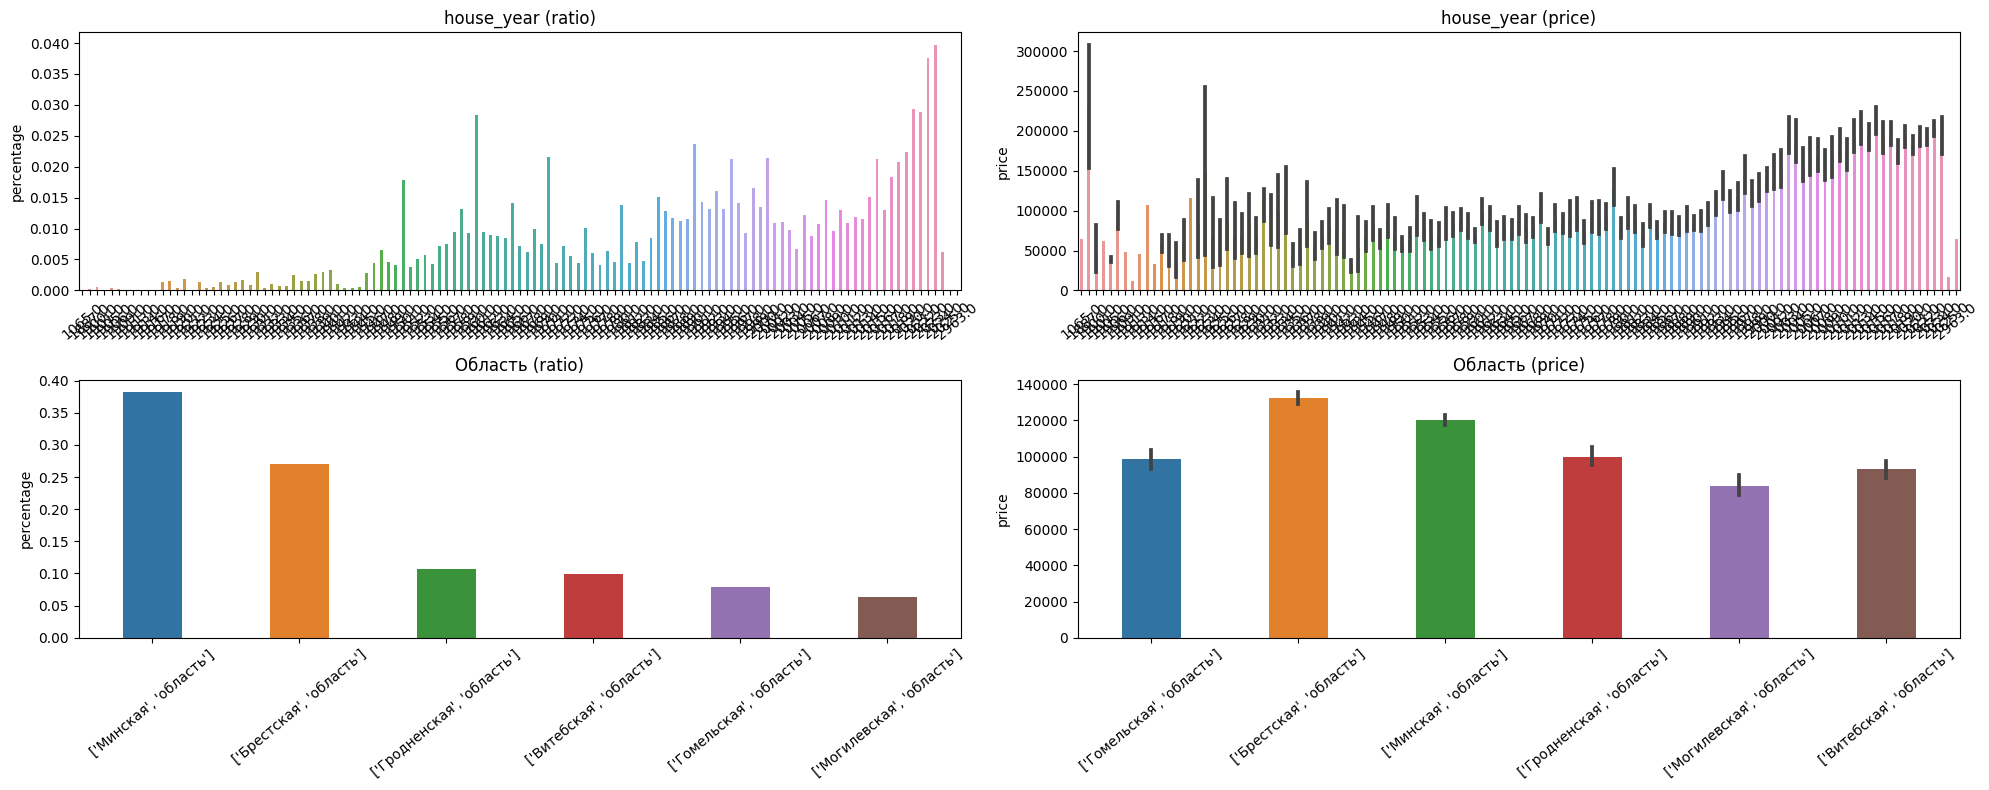

In [31]:
draw_categories(df,['house_year', 'Область'],20,40)

По признаку house_year прослеживается закономерность: чем новее дом, тем выше стоимость. однако здесь есть много пропусков. Попробуем преобразовать признак в категориальный путем разбиения на интервалы, а пробелы заполнить модальным значением. кроме того, мы удалим строки с годом меньше 1950 и значением цены больше медианного х2.
______________
For the house_year feature, a pattern can be traced: the newer the house, the higher the cost. however, there are many omissions here. Let's try to divide the sign into intervals, and fill the gaps with the modal value. in addition, we will delete rows with a year less than 1950 and a price value greater than the median x2

In [32]:
class CAT_3_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be managed before fillna '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        X['Направление'] = X['Направление'].apply(
            lambda x: re.findall(r'\'(\w{5,})\,.', x)[0] if x is not np.nan else x)
        X['Направление'] = X['Направление'].fillna('unknown')
        # добавим новый бинарный признак. расположение в городе
        X['in_city'] = X['Населенный пункт'].apply(
            lambda x: 1 if len(re.findall(r'\'([г]{1}\.)\'', x))==1 else 0)
        X['Населенный пункт'] = X['Населенный пункт'].apply(
            lambda x: (' ').join(re.findall(r'\'([А-Яа-я0-9]{1,})\'', x.replace('-','').replace('/','').replace('.',''))))
        
        #X['house_year'] = df['house_year'].fillna(df.groupby('Населенный пункт')['house_year'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
        #X['house_year'] = df['house_year'].fillna(df['house_year'].mode()[0])
        #X = X[(X['house_year']>1900) & (X['house_year']<2025)]
        X = X[~((X['house_year']<1950) & (X['price']>2*X['price'].median()))]
        X['year_group'] = pd.cut(
            X.house_year, [0,1900,1920,1940,1960,1980,2000,9999], 
            labels = ['<1900','1900-1920','1920-1940','1940-1960','1960-1980','1980-2000','2000+']) 
        X['year_group'] = X['year_group'].fillna(X['year_group'].mode()[0])


        X['Область'] = X['Область'].map({
            "['Гомельская', 'область']":'Гомель', 
            "['Минская', 'область']":'Минск', 
            "['Гродненская', 'область']":'Гродно', 
            "['Брестская', 'область']":'Брест',
            "['Могилевская', 'область']":'Могилев',
            "['Витебская', 'область']":'Витебск'
            })
        
        X['Район'] = X['Район'].apply(
            lambda x: re.findall(r'\'([А-Яа-я.]{1,})\'',x.replace('-',''))[0] if x is not np.nan else x)
        X.loc[X[X['Населенный пункт']=="г Минск"].index,'Район'] = 'Минск'
        X = X[X['Район'].notna()]
                
        largest_towns = X['Населенный пункт'].value_counts().nlargest(20).index
        X['Населенный пункт'] = X['Населенный пункт'].apply(lambda x: x if x in largest_towns else 'другой')
        
        X.drop(['house_year', 'Сельсовет'], axis=1, inplace=True)
                
        print(f"DF shape after CAT_3_Transformer {X.shape}")

        return X
    

cat_3_treat = CAT_3_Transformer(fill_na_manage)
df = cat_3_treat.transform(df)

DF shape after CAT_3_Transformer (12978, 39)


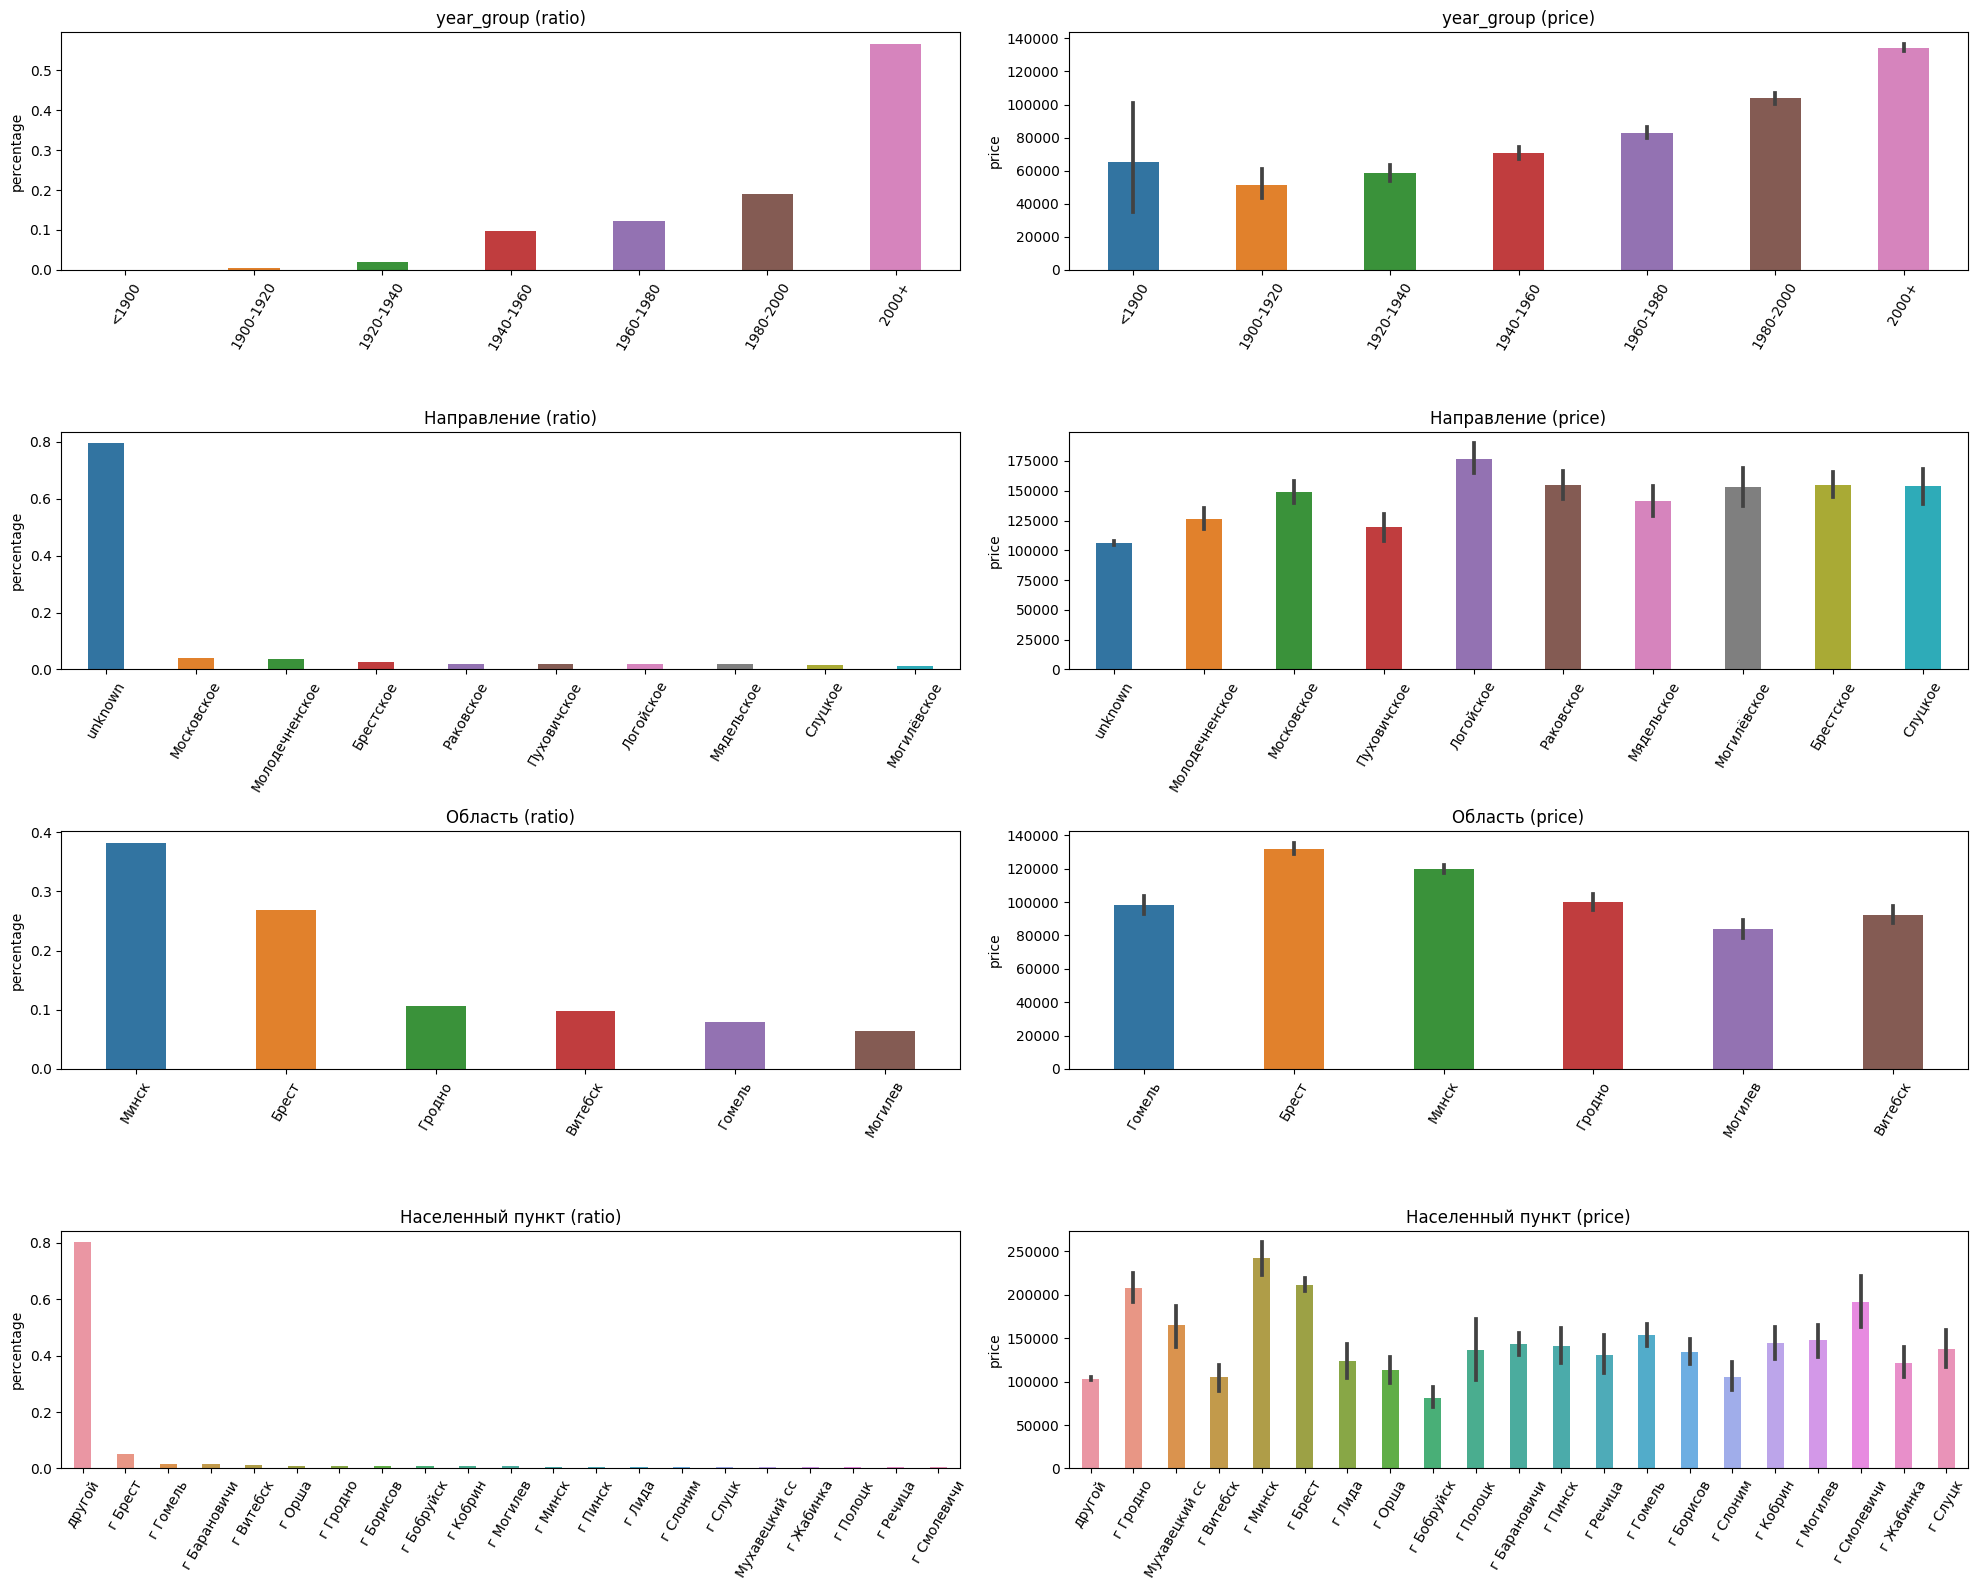

In [33]:
draw_categories(df,['year_group','Направление', 'Область', 'Населенный пункт'],20,60)

* разбиение года постройки на интервалы позволяет четко проследить закономерность увеличения стоимости с увеличением новизны здания
* Логойское направление – одно из самых дорогих.
* в Брестской и Минской областях - цены прогнозируемо самые высокие
* Среди регионов самая дорогая недвижимость в столице и близлежащих Смолевичах, а также в областных центрах Гродно и Бресте.
________________
* breaking down the year of construction into intervals makes it possible to clearly trace the pattern of increasing cost with increasing novelty of the building
* Logoisk direction is one of the most expensive
* in the Brest and Minsk regions - prices are predictably the highest
* Among the regions, the most expensive real estate is in the capital and nearby Smolevichi, as well as in the regional centers of Grodno and Brest.

### New features

Для генерации новых признаков был написан новый парсер (functions.get_district_details) для сбора координат районных центров. на основании чего было рассчитано расстояние от объекта в объявлении до районного центра, ближайшего областного центра и до столицы
______________
To generate a new features, it was necessary to write a new parser (functions.get_district_details) to collect the coordinates of district centers. on the basis of which the distance from the object in the ad to the city was calculated

In [34]:
district_dict = dict()


#for i in df['Район'].unique():
#    try:
#        district_dict[i] = get_district_details(i + ' район, Беларусь')
#    except:
#        print(i, "couldn't get data")
#        continue

#district_dict['Славгородский'] = [(53.2643, 30.5947), (53.2643, 30.5947)]

#df_district = pd.DataFrame(district_dict, index=['district_center_coordinates', 'district_city_coordinates']).T
#df_district.to_csv('data/districts.csv')

In [35]:
class NEW_4_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be managed before fillna '''

    def __init__(self):
        pass
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        #
        regions_dict = dict()
        regions = df['Область'].unique()

        for item in regions:
            if type(item) is str:
                regions_dict[item] = get_location(item + ', беларусь')
            else:
                continue


        X['regional_center_coordinates'] = X['Область'].apply(lambda x: str(regions_dict[x]) )

        # load the data from file with district coordinates, parsed before
        districts_df = pd.read_csv('data/districts.csv').rename(columns={'Unnamed: 0':'Район'})
        districts_df.loc[districts_df.shape[0]] = ['Минск','(53.55, 27.33)','(53.55, 27.33)']
        X = pd.merge(X, districts_df, how='left', on='Район')
        
        #df['distance_house_district_center'] = df.apply(lambda x: get_distance(x['house_coordinates'], x['district_center_coordinates']), axis=1)
        X['distance_house_district_city'] = X.apply(lambda x: get_distance(x['house_coordinates'], x['district_city_coordinates'], regions_dict), axis=1)
        #df['distance_house_region'] = df.apply(lambda x: get_distance(x['house_coordinates'], x['regional_center_coordinates'],1)[0], axis=1)
        X['distance_house_region_min'] = X.apply(lambda x: get_distance(x['house_coordinates'], x['regional_center_coordinates'],regions_dict,1)[1], axis=1)
        X['distance_house_minsk'] = X.apply(lambda x: get_distance(x['house_coordinates'], str(regions_dict['Минск']),regions_dict), axis=1)
        X['distances_multiply'] = X['distance_house_minsk'] * X['distance_house_region_min'] * X['distance_house_district_city']
        #X['distances_sum'] = X['distance_house_minsk'] + X['distance_house_region_min'] + X['distance_house_district_city']

        largest_districts = X['Район'].value_counts().nlargest(30).index
        X['Район'] = X['Район'].apply(lambda x: x if x in largest_districts else 'другой')

        print(f"DF shape after NEW_4_Transformer {X.shape}")

        return X
    

cat_4_treat = NEW_4_Transformer()
df = cat_4_treat.transform(df)


DF shape after NEW_4_Transformer (12978, 46)


Созданные трансформеры при необходимости можно собрать в pipeline.
______________
The created transformers can be assembled into a pipeline if necessary.

In [36]:
#pipeline = Pipeline([
#    ('NUM_Transformer', NUM_Transformer()),
#    ('BIN_Transformer', BIN_Transformer(bin_categories)),
#    ('CAT_1_Transformer', CAT_1_Transformer(fill_na_net)), 
#    ('CAT_2_Transformer', CAT_2_Transformer(fill_na_mode)), 
#    ('CAT_3_Transformer', CAT_3_Transformer(fill_na_manage)), 
#    ('NEW_4_Transformer', NEW_4_Transformer())
#    ])

#df = pipeline.fit_transform(df)
#df.shape

## Numerical features

давайте посмотрим на распределение значений целевого признака
________________
let's see how the target feature values are distributed

count     12978.000000
mean     114300.018108
std       97450.863529
min        1188.000000
25%       38905.000000
50%       81053.000000
75%      162750.000000
max      398778.000000
Name: price, dtype: float64

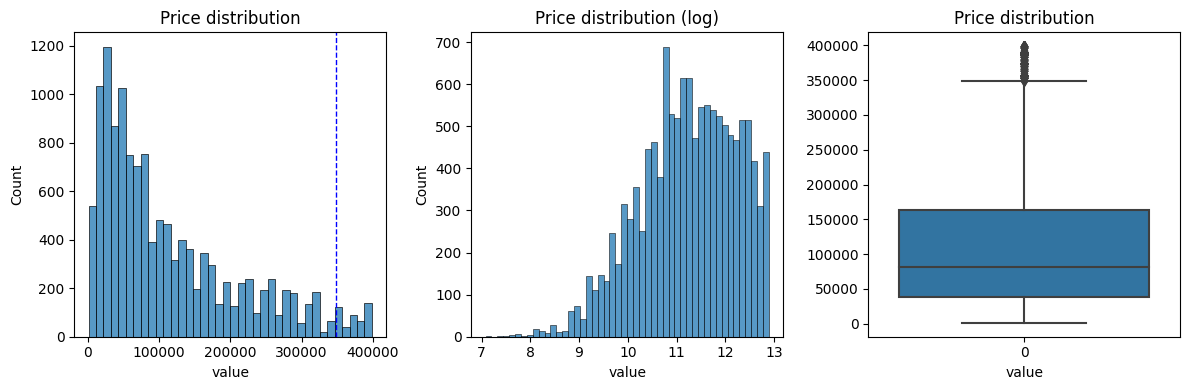

In [37]:
f,a = plt.subplots(1,3,figsize=(12,4))
x = df['price']
sns.histplot(x, ax=a[0]).set(title=f'Price distribution', xlabel='value');
sns.boxplot(x, ax=a[2]).set(title=f'Price distribution', xlabel='value');
sns.histplot(np.log(x), ax=a[1]).set(title=f'Price distribution (log)', xlabel='value');
a[0].axvline(x.quantile(0.75) + 1.5*(x.quantile(0.75)-x.quantile(0.25)), color='b', ls='--', lw=1)
plt.tight_layout()
x.describe()

Даже при ограничении целевого признака в первом трансформере заметно наличие выбросов. Распределение значений не является нормальным
_________________
Even with the target limited in the first transformer some outliers are visible. The distribution of values is not normal

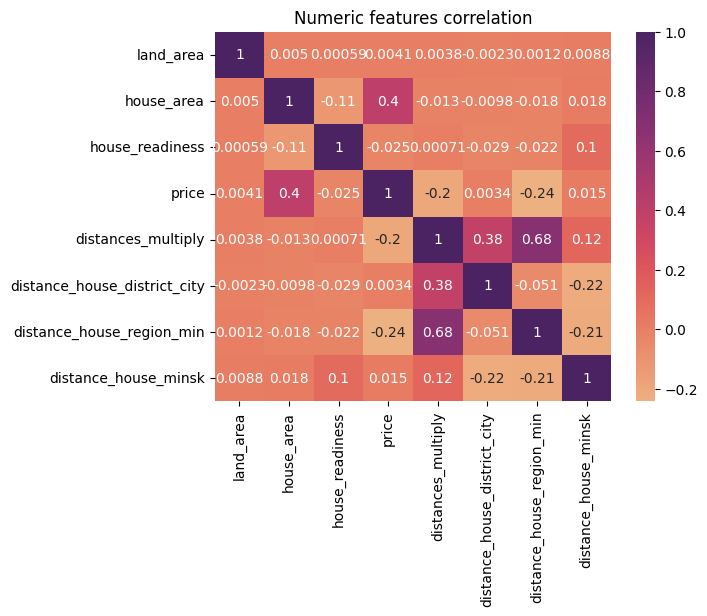

In [38]:
sns.heatmap(
    df.loc[:,num_features+['distances_multiply','distance_house_district_city','distance_house_region_min','distance_house_minsk']].corr(), 
    cmap='flare', 
    annot=True).set(title='Numeric features correlation');

относительно сильная корреляция между ценой и площадью дома вполне логична. Отрицательные коэффициенты с новыми сгенерированныи признаками (distance_multiply, distance_house_region) — также вполне логичны, так как чем больше расстояние от города, тем ниже должна быть цена.
________________
relatively strong correation between price and house area is really logical. There are negative correlations with generated features (distance_multiply, distance_house_region) - also quite logical as the longer the distance, the lower the price should be

### Handling outliers

Было решено удалять выбросы методом Тьюки, учитывая тип объекта. это положительно сказалось на метриках
_____________
It was decided to remove outliers using the Tjukey method by groups of object type. this had a positive effect on the metric

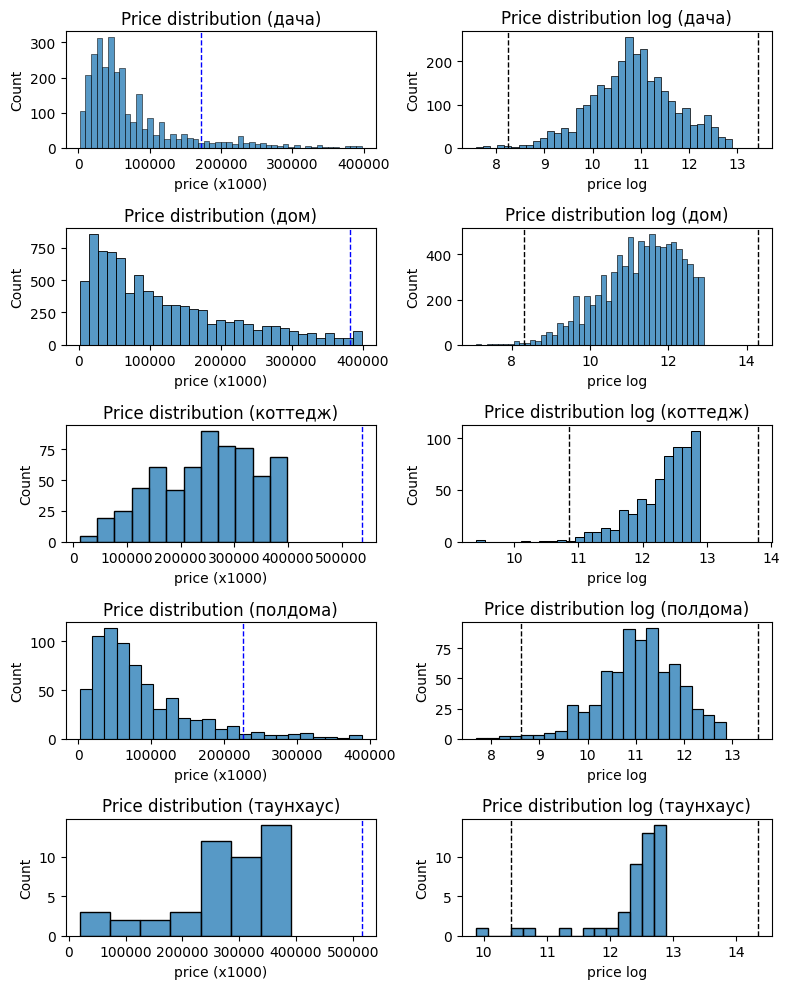

In [39]:
temp = df['Тип объекта'].unique()
f,a = plt.subplots(len(temp),2, figsize=(8,2*len(temp)))
for i,k in enumerate(temp):
    x = df[df['Тип объекта']==k]['price']
    sns.histplot(x, ax=a[i,0]).set(title=f'Price distribution ({k})', xlabel='price (x1000)');
    #a[i,0].axvline(x.mean(), color='r', lw=1)
    #a[i,0].axvline(x.quantile(0.25) - 1.5*(x.quantile(0.75)-x.quantile(0.25)), color='b', ls='--', lw=1)
    a[i,0].axvline(x.quantile(0.75) + 1.5*(x.quantile(0.75)-x.quantile(0.25)), color='b', ls='--', lw=1)
    
    sns.histplot(np.log(df[df['Тип объекта']==k]['price']), ax=a[i,1]).set(title=f'Price distribution log ({k})', xlabel='price log');
    #a[i,1].axvline(x.median(), color='k', lw=1)
    a[i,1].axvline(np.log(x).mean()+ 3 * np.log(x).std(), color='k', ls='--', lw=1)
    a[i,1].axvline(np.log(x).mean()- 3 * np.log(x).std(), color='k', ls='--', lw=1)

plt.tight_layout()

In [40]:
print(f"DF shape before outliers removing: {df.shape}")
df_cleaned = pd.DataFrame()
for i in df['Тип объекта'].unique():
    df_cleaned = pd.concat([df_cleaned, outliers_iqr_mod(df[df['Тип объекта']==i], 'price', right=1.5,log_scale=False)], axis=0)
    #df_cleaned = pd.concat([df_cleaned, outliers_z_score(df[df['Тип объекта']==i], 'price', right=2.0,left=2.0,log_scale=True)], axis=0)
    #print(f"DF shape after cleaning outliers from object {i}: {df_cleaned.shape}")

print(f"DF shape after outliers removing: {df_cleaned.shape}")

DF shape before outliers removing: (12978, 46)
DF shape after outliers removing: (12539, 46)


Кроме того, были удалены выбросы в новых признаках расстояний. Потому что максимальное расстояние до районного центра в 518 км нереально. и скорее всего результат ошибки ввода данных
______________
In addition, outliers in the new distance features were removed. Because the maximum distance to the regional center of 518 km is not realistic. and most likely the result of a data entry error 

In [41]:
df.loc[:,['distance_house_district_city', 'distance_house_region_min','distance_house_minsk']].describe()

,distance_house_district_city,distance_house_region_min,distance_house_minsk
count,12978.000000,12978.000000,12978.000000
mean,29.425343,56.942865,167.956819
std,17.656555,47.264610,108.153687
min,0.100000,0.200000,2.300000
25%,18.200000,17.500000,65.800000
50%,27.100000,41.850000,158.850000
75%,39.000000,92.475000,270.600000
max,518.200000,221.400000,372.300000


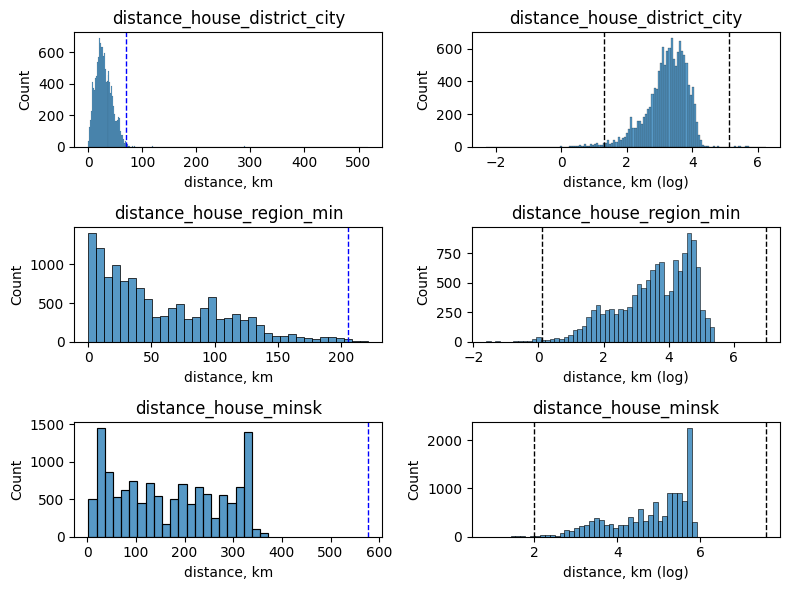

In [42]:
f,a = plt.subplots(3,2, figsize=(8,2*3))
for i,k in enumerate(['distance_house_district_city', 'distance_house_region_min','distance_house_minsk']):
    x = df[k]
    sns.histplot(x, ax=a[i,0]).set(title=f'{k}', xlabel='distance, km');
    a[i,0].axvline(x.quantile(0.75) + 1.5*(x.quantile(0.75)-x.quantile(0.25)), color='b', ls='--', lw=1)
    
    sns.histplot(np.log(x), ax=a[i,1]).set(title=f'{k}', xlabel='distance, km (log)');
    a[i,1].axvline(np.log(x).mean()+ 3 * np.log(x).std(), color='k', ls='--', lw=1)
    a[i,1].axvline(np.log(x).mean()- 3 * np.log(x).std(), color='k', ls='--', lw=1)
plt.tight_layout()

In [43]:
print(f"DF shape before outliers removing: {df_cleaned.shape}")

for item in ['distance_house_district_city', 'distance_house_region_min','distance_house_minsk','house_area']:
    df_cleaned = outliers_iqr_mod(df_cleaned, item, right=1.5,left=1.5, log_scale=False)
    print(f"DF shape after removing outliers in {item}: {df_cleaned.shape}")
    
print(f"DF shape after outliers removing: {df_cleaned.shape}")

DF shape before outliers removing: (12539, 46)
DF shape after removing outliers in distance_house_district_city: (12469, 46)
DF shape after removing outliers in distance_house_region_min: (12448, 46)
DF shape after removing outliers in distance_house_minsk: (12448, 46)
DF shape after removing outliers in house_area: (11477, 46)
DF shape after outliers removing: (11477, 46)


In [44]:
df_cleaned.loc[:,['distance_house_district_city', 'distance_house_region_min','distance_house_minsk', 'house_area']].describe()

,distance_house_district_city,distance_house_region_min,distance_house_minsk,house_area
count,11477.000000,11477.000000,11477.000000,11477.000000
mean,28.826017,58.335279,166.281023,80.813003
std,14.519771,46.778736,106.555603,36.613110
min,0.100000,0.200000,2.300000,1.000000
25%,17.900000,19.500000,67.600000,53.300000
50%,27.000000,44.300000,150.000000,77.900000
75%,38.800000,93.800000,257.000000,97.000000
max,70.500000,206.200000,372.300000,190.100000


после удаления выбросов, описательные статистики выглядят более адекватными и логичными
___________
after removing outliers, descriptive statistics look more adequate and logical

### Coding categorial features

In [45]:
ohe_list = ['Материал стен', 'Материал крыши', 'Отопление', 'Канализация', 'Электроснабжение', 
           'Вода','Область',  'Газ',  'Ремонт', 'Район','year_group', 'Тип объекта', 'Населенный пункт']#'Статус земли', 'Направление', 

encoder = ce.OneHotEncoder(cols=ohe_list, use_cat_names=True)
oh_data = encoder.fit_transform(df_cleaned.loc[:,ohe_list])
dff = pd.concat([df_cleaned,oh_data], axis=1).drop(ohe_list, axis=1)

dff = dff.drop(['house_coordinates','regional_center_coordinates',  'Статус земли', 
                'Направление', 'district_center_coordinates','district_city_coordinates'], axis=1)
#dff = dff.drop(['distances_sum','distance_house_district_city','distance_house_region_min','distance_house_minsk'], axis=1) # 'distances_multiply',

dff.shape

(11477, 154)

## Modeling

In [46]:
logger.info(f"price < 400000")

In [47]:
X = dff.drop('price', axis=1)
y = dff['price']
col_names = X.columns



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)


scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_df = pd.DataFrame(X_train, columns=col_names)
X_test_df = pd.DataFrame(X_test, columns=col_names)

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

X_train_df.head(3)


Train shape: (9181, 153)
Test shape: (2296, 153)


,Телефон,Баня,Гараж,Сад,Хозпостройки,Рядом лес,Водоем,Ландшафтный дизайн,Теплица,Мебель,...,Населенный пункт_г Пинск,Населенный пункт_г Речица,Населенный пункт_г Гомель,Населенный пункт_г Борисов,Населенный пункт_г Кобрин,Населенный пункт_г Слоним,Населенный пункт_г Смолевичи,Населенный пункт_г Жабинка,Населенный пункт_г Могилев,Населенный пункт_г Слуцк
6460,0,1,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
942,0,0,1,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2680,0,0,0,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


### Base model

In [48]:
# base model
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred)
display(errs)
logger.info(f"______lr | r2:{errs['r2'].values}, mae: {errs['mae'].values}")

,r2,mae
TRAIN,0.68,34215.44
TEST,0.68,35034.84


### Boosting

In [49]:
params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

gs = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=33), 
    param_grid=params,
    scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
    cv=3, 
    n_jobs = -1
)  

gs.fit(X_train, y_train) 
#gs.fit(X_train, y_train_log) 

y_train_pred = gs.predict(X_train)
y_test_pred = gs.predict(X_test)
#y_train_pred = np.exp(gs.predict(X_train))
#y_test_pred = np.exp(gs.predict(X_test))


errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred)
display(errs)
logger.info(f"______gs | r2:{errs['r2'].values}, mae: {errs['mae'].values}")

,r2,mae
TRAIN,0.74,29577.60
TEST,0.72,31787.52


R2 выше чем 0.5, это хорошо, т.е. предсказание модели лучше чем среднее по выборке. Однако MAE хотелось бы улучшить.

посмотрим на разброс значений по метрике MAE
__________________
R2 is higher than 0.5, this is good, i.e. The model's prediction is better than the sample average. However, MAE would like to be improved.

Let's look at the spread of MAE metric values

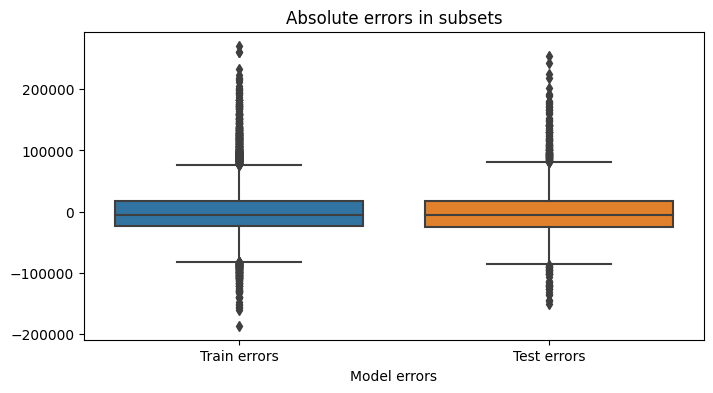

In [50]:
y_train_errors = y_train - y_train_pred
y_test_errors = y_test - y_test_pred
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors}
     )

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=predict_df, ax=ax).set(title='Absolute errors in subsets', xlabel='Model errors');

Видим, что в некоторых случаях абсолютная ошибка чрезвычано большая. скорее всего этого связано с неадекватной оценкой недвижимости, возможно желанием продать подороже. есть смысл избавиться от таких данных, т.к. они сильно влияют на качество прогноза
______
In some cases the absolute error is extremely large. Most likely this is due to an inadequate valuation of the property, perhaps a desire to sell at a higher price. It makes sense to remove such kind of data, because they greatly influence the quality of the forecast

In [51]:
err_outliers_train = y_train_errors[abs(y_train_errors)>80000].index
err_outliers_test = y_test_errors[abs(y_test_errors)>80000].index
print(f"Error outliers train/test: {X_train_df.loc[err_outliers_train].shape},{X_test_df.loc[err_outliers_test].shape}")


X_train = X_train_df[~X_train_df.index.isin(err_outliers_train)]
y_train = y_train[~y_train.index.isin(err_outliers_train)]
X_test = X_test_df[~X_test_df.index.isin(err_outliers_test)]
y_test = y_test[~y_test.index.isin(err_outliers_test)]
print(f"Shape after cleaning train/test: {X_train.shape}, {X_test.shape}")

Error outliers train/test: (621, 153),(180, 153)
Shape after cleaning train/test: (8560, 153), (2116, 153)


In [52]:
params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

gs = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=33), 
    param_grid=params,
    scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
    cv=3, 
    n_jobs = -1
)  

gs.fit(X_train, y_train) 
#gs.fit(X_train, y_train_log) 

y_train_pred = gs.predict(X_train)
y_test_pred = gs.predict(X_test)
#y_train_pred = np.exp(gs.predict(X_train))
#y_test_pred = np.exp(gs.predict(X_test))


errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred)
display(errs)
logger.info(f"gserrout | r2:{errs['r2'].values}, mae: {errs['mae'].values}")

,r2,mae
TRAIN,0.84,22783.20
TEST,0.81,24300.54


Удаление выбросов по MAE положительно сказалось на обеих метриках
_____
Removing MAE outliers had a positive impact on both metrics

### Bagging

In [53]:
def optuna_rf(trial):
    """ optimize hyperparameters using optuna module """
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 1, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=33
        )
  
    model.fit(X_train, y_train)
    #score = metrics.r2_score(y_train_log, model.predict(X_train_scaled))
    score = metrics.mean_absolute_error(y_test, model.predict(X_test))
    #score_train = metrics.r2_score(y_train, model.predict(X_train))
    #score = score_test / (score_train-score_test)

    return score


study = optuna.create_study(study_name="RandomForestRegressor", direction="minimize")
study.optimize(optuna_rf, n_trials=20)

print(f"Best hyperparameters {study.best_params}")
print(f"Best score: {study.best_value}")

#--> Best hyperparameters {'n_estimators': 129, 'max_depth': 25, 'min_samples_leaf': 10}

[I 2024-05-03 11:35:19,763] A new study created in memory with name: RandomForestRegressor
[I 2024-05-03 11:35:22,605] Trial 0 finished with value: 31195.403217850362 and parameters: {'n_estimators': 113, 'max_depth': 5, 'min_samples_leaf': 9}. Best is trial 0 with value: 31195.403217850362.
[I 2024-05-03 11:35:26,964] Trial 1 finished with value: 29860.45448067009 and parameters: {'n_estimators': 145, 'max_depth': 6, 'min_samples_leaf': 7}. Best is trial 1 with value: 29860.45448067009.
[I 2024-05-03 11:35:32,740] Trial 2 finished with value: 26052.058892722744 and parameters: {'n_estimators': 109, 'max_depth': 14, 'min_samples_leaf': 8}. Best is trial 2 with value: 26052.058892722744.
[I 2024-05-03 11:35:41,188] Trial 3 finished with value: 25248.56708782518 and parameters: {'n_estimators': 118, 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 3 with value: 25248.56708782518.
[I 2024-05-03 11:35:43,835] Trial 4 finished with value: 36131.42815209512 and parameters: {'n_estimato

Best hyperparameters {'n_estimators': 145, 'max_depth': 30, 'min_samples_leaf': 2}
Best score: 25071.16279064962


In [54]:
rfr = RandomForestRegressor(**study.best_params,random_state=33)
#rfr = RandomForestRegressor(n_estimators= 129, max_depth = 25, min_samples_leaf = 10,random_state=33)

rfr.fit(X_train, y_train)

y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)

errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred)
display(errs)
logger.info(f"_____rfr | r2:{errs['r2'].values}, mae: {errs['mae'].values}")

,r2,mae
TRAIN,0.96,11084.61
TEST,0.79,25071.16


RandomForrestRegressor ожидаемо показывает лучший результат на train, что приводит к переобучению
__________________
RandomForestRegressor predictably shows the best result on train, which leads to overfitting

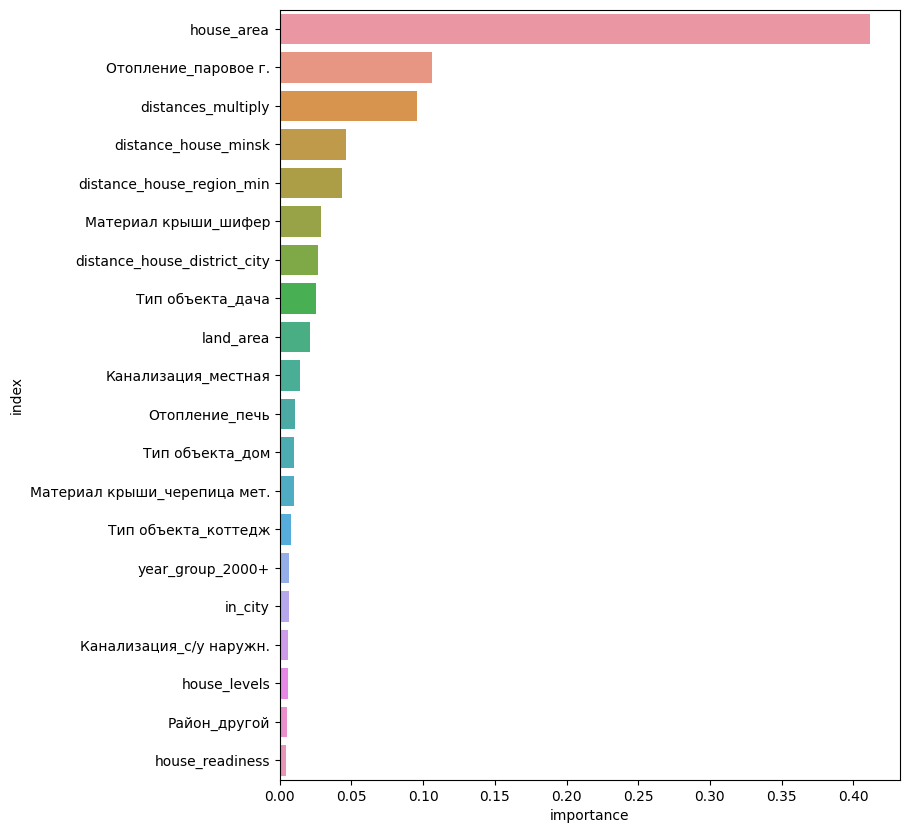

In [55]:
imp_df = pd.DataFrame({'index': X_train.columns, 'importance':rfr.feature_importances_}).sort_values(by='importance', ascending=False).nlargest(columns='importance',n=20)

f,a = plt.subplots(figsize=(8,10))
sns.barplot(y=imp_df['index'], x=imp_df.importance, orient='h');

учитывая важность признаков по версии RandomForestRegressor его можно использовать в качестве селектора признаков для обучения модели на основе Boosting, которые, как правило, обеспечивают меньший разброс.

In [56]:
# fit the model with train includind 20 best feature according to RandomForrestRegressor 
params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

gs = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=33), 
    param_grid=params,
    scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
    cv=3, 
    n_jobs = -1
)  

gs.fit(X_train[imp_df['index'].values[:20]], y_train) 
#gs.fit(X_train[imp_df['index'].values[:20]], y_train_log) 

y_train_pred = gs.predict(X_train[imp_df['index'].values[:20]])
y_test_pred = gs.predict(X_test[imp_df['index'].values[:20]])
#y_train_pred = np.exp(gs.predict(X_train[imp_df['index'].values[:20]]))
#y_test_pred = np.exp(gs.predict(X_test[imp_df['index'].values[:20]]))


errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred)
display(errs)
logger.info(f"__gs_imp | r2:{errs['r2'].values}, mae: {errs['mae'].values}")

,r2,mae
TRAIN,0.81,24353.79
TEST,0.79,25614.45


подберем оптимальное количество признаков для финальной модели, используя SelectKBest
_____________
select the optimal number of features for the final model using SelectKBest

In [57]:
# let's manage to choose best features quantity for final model
train_scores_r2 = []
test_scores_r2 = []
train_scores_mae = []
test_scores_mae = []

for i in np.arange(20, X_train.shape[1],20):
    selector = SelectKBest(f_regression, k=i)
    selector.fit(X_train, y_train)
    best_fea = selector.get_feature_names_out()

    params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

    gs = GridSearchCV(
        estimator=GradientBoostingRegressor(random_state=33), 
        param_grid=params,
        scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
        cv=3, 
        n_jobs = -1
    )  

    gs.fit(X_train[best_fea], y_train) 
    #gs.fit(X_train_df[best_fea], y_train_log) 

    y_train_pred = gs.predict(X_train[best_fea])
    y_test_pred = gs.predict(X_test[best_fea])
    
    
    #y_train_pred = np.exp(gs.predict(X_train_df[best_fea]))
    #y_test_pred = np.exp(gs.predict(X_test_df[best_fea]))

    train_scores_r2.append(metrics.r2_score(y_train, y_train_pred))
    test_scores_r2.append(metrics.r2_score(y_test, y_test_pred))
    train_scores_mae.append(metrics.mean_absolute_error(y_train, y_train_pred))
    test_scores_mae.append(metrics.mean_absolute_error(y_test, y_test_pred))
    #metrics.mean_absolute_error(y_test, y_test_pred)


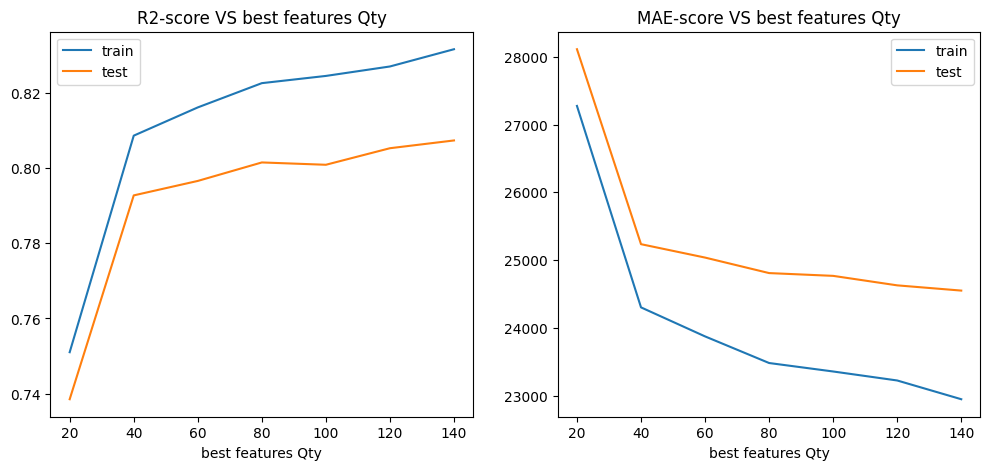

In [58]:
f,a = plt.subplots(1,2,figsize=(12,5))
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=train_scores_r2, ax=a[0], label='train').set(title='R2-score VS best features Qty', xlabel='best features Qty');
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=test_scores_r2, ax=a[0], label='test');
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=train_scores_mae, ax=a[1], label='train').set(title='MAE-score VS best features Qty', xlabel='best features Qty');
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=test_scores_mae, ax=a[1], label='test');

it seems than 40 features are optimal

In [59]:
n = 40
selector = SelectKBest(f_regression, k=n)
selector.fit(X_train, y_train)
 
best_fea = selector.get_feature_names_out()
best_fea

array(['Гараж', 'Новостройка', 'Элитный коттедж', 'house_area',
       'house_levels', 'in_city', 'distance_house_region_min',
       'distances_multiply', 'Материал стен_дерево',
       'Материал стен_блок г/с', 'Материал стен_блок',
       'Материал крыши_шифер', 'Материал крыши_черепица мет.',
       'Материал крыши_черепица мяг.', 'Отопление_печь',
       'Отопление_электрич.', 'Отопление_паровое г.',
       'Канализация_местная', 'Канализация_нет',
       'Канализация_с/у наружн.', 'Канализация_центральн.',
       'Вода_сезонная', 'Вода_водопровод', 'Вода_колодец',
       'Вода_рядом колодец', 'Газ_нет', 'Газ_есть', 'Ремонт_отделка дер.',
       'Ремонт_евроотделка', 'Район_Брестский', 'Район_другой',
       'Район_Минский', 'year_group_2000+', 'Тип объекта_дача',
       'Тип объекта_дом', 'Тип объекта_коттедж', 'Тип объекта_таунхаус',
       'Населенный пункт_другой', 'Населенный пункт_г Минск',
       'Населенный пункт_г Брест'], dtype=object)

In [60]:
# final model fit with train subset locked to best feature selected
params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

gs = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=33), 
    param_grid=params,
    scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
    cv=3, 
    n_jobs = -1
)  

gs.fit(X_train[best_fea], y_train) 
#gs.fit(X_train[best_fea], y_train_log) 

y_train_pred = gs.predict(X_train[best_fea])
y_test_pred = gs.predict(X_test[best_fea])
#y_train_pred = np.exp(gs.predict(X_train[best_fea]))
#y_test_pred = np.exp(gs.predict(X_test[best_fea]))


errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred)
display(errs)
logger.info(f"gs_kbest | r2:{errs['r2'].values}, mae: {errs['mae'].values}, n_best={n}")

,r2,mae
TRAIN,0.81,24302.26
TEST,0.79,25234.78


In [61]:
# dump the model for deployment
with open('model.pkl', 'wb') as output:
    pickle.dump(gs, output)

with open('model.pkl', 'rb') as pkl_file:
    model = pickle.load(pkl_file)

model

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=33),
             n_jobs=-1,
             param_grid={'learning_rate': array([1.  , 0.1 , 0.01]),
                         'max_depth': array([1, 2, 3]),
                         'n_estimators': array([  1,   2,   4,   8,  16,  32,  64, 128])},
             scoring='neg_root_mean_squared_error')

    * Т.о. оптимальной с точки зрения обеих метрик оказалась модель на основе Boosting. 
    * Полученные значения по метрикам не идеальны, однако выше ожидаемых изначально. 
    * улучшение модели представляется возможным при увеличении объема и качества данных. Похоже, что того набора параметров, которые использованы на сайте realt.by, не достаточно для улавливания моделью различий между объектами особенно высокой ценовой категории. 
    * У нас получилось отобрать 40 признаков наиболее ценных для модели. Они же и будут использоваться для инференса модели и оформления front-end части web-приложения. последнее доступно для тестирования по url: https://housespriceprediction-production.up.railway.app/
_________________
    * The model based on Boosting turned out to be optimal in terms of both metrics.
    * The obtained values for the metrics are not ideal, but they are higher than initially expected.
    * improvement of the model is possible with an increase in the volume and quality of data. It seems that the set of parameters used on the realt.by website is not enough for the model to capture the differences between objects in a particularly high price category.
    * We managed to select 40 features that are most valuable for the model. They will also be used for model inference and design of the front-end part of the web application, which is available for testing at url: https://housespriceprediction-production.up.railway.app/